# Question 2
The CMS collaboration has an automated job submission system that runs jobs as "cmslocal" and "cmspilot".

For these two users, jobs have internal system tests that will terminate their jobs early after approximately 30 minutes.

Do any of their jobs that ended in under an hour also cluster on specific compute nodes, 
suggesting possbily unreliable systems? 

Check both “production” and “nogpfs” partitions. 

Look for commonly failing nodes and compare with other failed jobs.

In [109]:
import numpy as np 
import pandas as pd 
import re
from io import StringIO
from datetime import time

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [110]:
# reformat the CSV to use | instead of , to separate rows, then import [a selection] of the data as a dataframe
for_pd = StringIO()
with open('../data/accre-jobs-2020.csv') as accre:
    for line in accre:
        new_line = re.sub(r',', '|', line.rstrip(), count=12)
        print (new_line, file=for_pd)

for_pd.seek(0)

accre_df = pd.read_csv(for_pd, sep='|')#[1000000:1005000] # add this to subset
accre_df.head()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,0:0,COMPLETED,cn1464
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,0:0,COMPLETED,cn1473
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,0:0,COMPLETED,cn1440


In [111]:
accre_df[accre_df['ACCOUNT'] == 'cms']

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST
2125,17032244,cms,cmspilot,28000Mn,8320.07M,2-00:00:00,1-23:31:46,1,4,production,0:0,COMPLETED,cn1205
2126,17032568,cms,cmspilot,28000Mn,11954.84M,2-00:00:00,1-23:33:13,1,4,production,0:0,COMPLETED,cn1492
2127,17032569,cms,cmspilot,28000Mn,10498.84M,2-00:00:00,1-23:36:36,1,4,production,0:0,COMPLETED,cn1497
2128,17032916,cms,cmspilot,21875Mn,11728.02M,2-00:00:00,1-23:27:55,1,8,nogpfs,0:0,COMPLETED,ng1037
2129,17032920,cms,cmspilot,94451Mn,20659.08M,2-00:00:00,1-23:16:04,1,8,nogpfs,0:0,COMPLETED,ng691
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816273,24173808,cms,uscmslocal,5000Mn,0,2-00:00:00,00:04:04,1,1,production,0:0,RUNNING,cn404
3816274,24173809,cms,uscmslocal,28000Mn,0,2-00:00:00,00:04:05,1,4,production,0:0,RUNNING,cn1378
3816275,24173810,cms,uscmslocal,5000Mn,0,2-00:00:00,00:04:04,1,1,production,0:0,RUNNING,cn407
3816276,24173811,cms,uscmslocal,28000Mn,0,2-00:00:00,00:04:05,1,4,production,0:0,RUNNING,cn1507


### Converting to seconds

In [112]:
accre_df['hours_min_sec_req'] = accre_df['REQTIME'].str[-8:]
accre_df['hours_min_sec_used'] = accre_df['USEDTIME'].str[-8:]

In [113]:
accre_df['day_req'] = accre_df['REQTIME'].str.extract('(.*?)-')
accre_df['day_used'] = accre_df['USEDTIME'].str.extract('(.*?)-')

In [114]:
accre_df['day_req'] = accre_df['day_req'].fillna(0)
accre_df['day_used'] = accre_df['day_used'].fillna(0)

In [115]:
# converting to the correct type
accre_df['day_req'] = accre_df['day_req'].astype(int)
accre_df['day_used'] = accre_df['day_used'].astype(int)

In [116]:
#converting to timedelta to then use total_seconds
accre_df['hours_min_sec_req'] =  pd.to_timedelta(accre_df['hours_min_sec_req'], unit='s')
accre_df['hours_min_sec_used'] =  pd.to_timedelta(accre_df['hours_min_sec_used'], unit='s')
accre_df['hours_min_sec_req'] = accre_df['hours_min_sec_req'].dt.total_seconds()
accre_df['hours_min_sec_used'] = accre_df['hours_min_sec_used'].dt.total_seconds()

In [121]:
#makes total seconds columns 
accre_df['total_sec_req'] = (accre_df['day_req'] * 86400) + accre_df['hours_min_sec_req']
accre_df['total_sec_used'] = (accre_df['day_used'] * 86400) + accre_df['hours_min_sec_used']

In [122]:
accre_df.head(70)

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,hours_min_sec_req,hours_min_sec_used,day_req,day_used,total_sec_req,total_sec_used
0,15925210,treviso,arabella,122880Mn,65973.49M,13-18:00:00,13-18:00:28,1,24,production,0:0,COMPLETED,cn1531,64800.0,64828.0,13,13,1188000.0,1188028.0
1,15861126,treviso,arabella,122880Mn,67181.12M,13-18:00:00,12-14:50:56,1,24,production,0:0,COMPLETED,cn1441,64800.0,53456.0,13,12,1188000.0,1090256.0
2,15861125,treviso,arabella,122880Mn,69111.86M,13-18:00:00,13-18:00:20,1,24,production,0:0,COMPLETED,cn1464,64800.0,64820.0,13,13,1188000.0,1188020.0
3,16251645,treviso,arabella,122880Mn,65317.33M,13-18:00:00,12-03:50:32,1,24,production,0:0,COMPLETED,cn1473,64800.0,13832.0,13,12,1188000.0,1050632.0
4,16251646,treviso,arabella,122880Mn,65876.11M,13-18:00:00,13-18:00:03,1,24,production,0:0,COMPLETED,cn1440,64800.0,64803.0,13,13,1188000.0,1188003.0
5,16297022,treviso,arabella,122880Mn,65183.02M,13-18:00:00,12-02:31:43,1,24,production,0:0,COMPLETED,cn1443,64800.0,9103.0,13,12,1188000.0,1045903.0
6,16297024,treviso,arabella,122880Mn,64941.85M,13-18:00:00,13-06:54:59,1,24,production,0:0,COMPLETED,cn1531,64800.0,24899.0,13,13,1188000.0,1148099.0
7,16316283,treviso,arabella,122880Mn,68499.51M,13-18:00:00,13-18:00:05,1,24,production,0:0,COMPLETED,cn1535,64800.0,64805.0,13,13,1188000.0,1188005.0
8,16316284,treviso,arabella,122880Mn,67761.41M,13-18:00:00,13-18:00:15,1,24,production,0:0,COMPLETED,cn1464,64800.0,64815.0,13,13,1188000.0,1188015.0
9,16316324,treviso,arabella,122880Mn,68087.66M,13-18:00:00,13-18:00:06,1,24,production,0:0,COMPLETED,cn1473,64800.0,64806.0,13,13,1188000.0,1188006.0


# Cleaning CMS Account Data

In [52]:
#subsetting data for cms account
cms_df = accre_df[accre_df['ACCOUNT']=='cms']

#subsetting data to get rid of debug partition
cms_df = cms_df[cms_df['PARTITION']!='debug']

#subsetting data for only 'cmspilot' and 'cmslocal' users
cms_df = cms_df[(cms_df['USER']=='cmspilot')|(cms_df['USER']=='cmslocal')]

In [53]:
#getting time under an hour
cms_df['under_hour'] = False

for index, row in cms_df.USEDTIME.iteritems():
    chopped_row = str(row).split(":")
    
    if chopped_row[0] == '00':
        cms_df['under_hour'][index] = True

C:\Users\savro\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
#subsetting for time under an hour
cms_df = cms_df[cms_df['under_hour'] == True]

In [55]:
#making a minutes column to see time distribution
cms_df['minutes'] = -1

for index, row in cms_df.USEDTIME.iteritems():
    chopped_row = str(row).split(":")
    cms_df['minutes'][index] = chopped_row[1]
    

C:\Users\savro\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
cms_df['minutes'] = cms_df['minutes'].astype(int)

In [57]:
#getting only failed jobs
#using state != to complete instead of exit code beacuse its built in their code to crash and error might not be reflected in exit code
cms_failed = cms_df[cms_df['STATE'] != 'COMPLETED']
cms_completed = cms_df[cms_df['STATE'] == 'COMPLETED']

# EDA and Analysis

In [58]:
pd.crosstab(cms_df['EXITCODE'],cms_df['STATE']).apply(lambda x: (x/x.sum()), axis=1)

STATE,CANCELLED,CANCELLED by 9201,CANCELLED by 9202,COMPLETED,FAILED,RUNNING
EXITCODE,,,,,,
0:0,0.003442,0.000007,0.000007,0.996388,0.000000,0.000157
0:9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
126:0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
127:0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1:0,0.733333,0.000000,0.000000,0.000000,0.266667,0.000000


### How often are jobs canceling around 30 minutes for account CMS?

In [33]:
cms_df.head()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,under_hour,minutes
8001,17093431,cms,cmslocal,21875Mn,1.84M,2-00:00:00,00:22:07,1,8,nogpfs,0:0,COMPLETED,ng1017,True,22
8002,17093435,cms,cmslocal,21875Mn,1.82M,2-00:00:00,00:21:51,1,8,nogpfs,0:0,COMPLETED,ng1027,True,21
8004,17093439,cms,cmslocal,21875Mn,1.18M,2-00:00:00,00:20:24,1,8,nogpfs,0:0,COMPLETED,ng1020,True,20
8005,17093440,cms,cmslocal,21875Mn,1.18M,2-00:00:00,00:20:24,1,8,nogpfs,0:0,COMPLETED,ng1036,True,20
8006,17093441,cms,cmslocal,21875Mn,1.17M,2-00:00:00,00:20:31,1,8,nogpfs,0:0,COMPLETED,ng1003,True,20


In [36]:
cms_min_sorted = cms_df.sort_values(by = ['minutes'], axis = 0)
cms_min_sorted.head()

,JOBID,ACCOUNT,USER,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,STATE,NODELIST,under_hour,minutes
3813303,24156810,cms,cmspilot,186648Mn,0,2-00:00:00,00:00:00,1,32,nogpfs,0:0,COMPLETED,cn1554,True,0
1618175,19729572,cms,cmspilot,28000Mn,1.81M,2-00:00:00,00:00:43,1,4,production,0:0,COMPLETED,cn1515,True,0
1618176,19729573,cms,cmspilot,28000Mn,1.27M,2-00:00:00,00:00:43,1,4,production,0:0,COMPLETED,cn1520,True,0
1618177,19729574,cms,cmspilot,28000Mn,13.44M,2-00:00:00,00:00:43,1,4,production,0:0,COMPLETED,cn1487,True,0
1618178,19729575,cms,cmspilot,28000Mn,13.44M,2-00:00:00,00:00:42,1,4,production,0:0,COMPLETED,cn1487,True,0


Text(0, 0.5, 'Number of Jobs Ended')

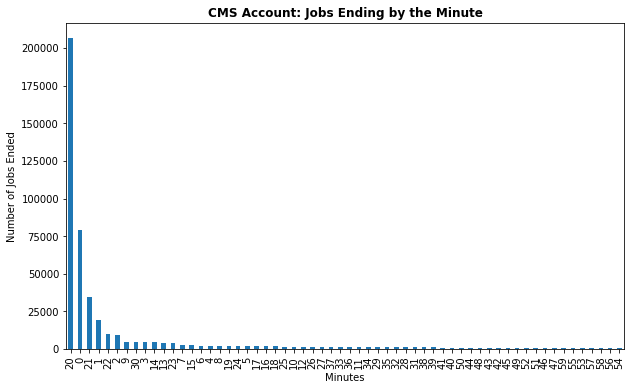

In [43]:
#looking at the distribution over time for minutes colun (all jobs under an hour

ax = cms_min_sorted['minutes'].value_counts().plot(kind = 'bar', figsize = (10,6))
ax.set_title('CMS Account: Jobs Ending by the Minute',weight='bold', size='large')
ax.set_xlabel('Minutes')
ax.set_ylabel('Number of Jobs Ended')


In [ ]:
#how many jobs are canceling around 30 minutes
#what percent of CMS total jobs are canceling around 30 minutes

#if time: 
#how does this compare to other major accounts jobs canceling around 30 minutes

### Most Failed Nodes for CMS Account

In [11]:
most_failed_nodes = cms_df['NODELIST'].value_counts().head(20)

Text(0, 0.5, 'Number of Time Failed')

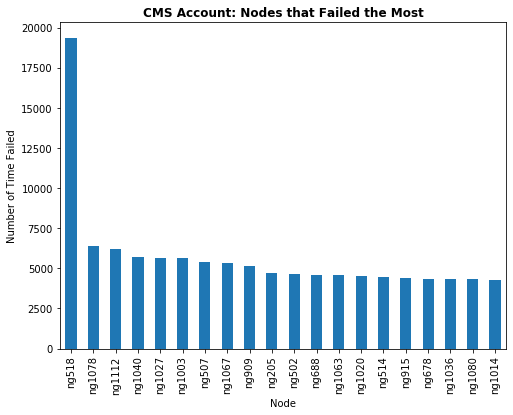

In [38]:
ax = most_failed_nodes.plot(kind = 'bar', figsize = (8,6))
ax.set_title('CMS Account: Nodes that Failed the Most',weight='bold', size='large')
ax.set_xlabel('Node')
ax.set_ylabel('Number of Time Failed')

In [13]:
most_failed_nodes.head(10)

ng518     19352
ng1078     6388
ng1112     6171
ng1040     5677
ng1027     5645
ng1003     5629
ng507      5400
ng1067     5357
ng909      5160
ng205      4691
Name: NODELIST, dtype: int64

### Percent of Times that Nodes Failed for CMS Account

In [14]:
#Count of failed nodes for new df for percents
cms_failed['NODELIST'].value_counts().head()

ng518     16
cn1314    12
cn394     11
ng734     10
cn475      9
Name: NODELIST, dtype: int64

In [15]:
#Count of successful nodes for new df for percents
cms_completed['NODELIST'].value_counts().head()

ng518     19336
ng1078     6382
ng1112     6162
ng1040     5671
ng1027     5640
Name: NODELIST, dtype: int64

In [16]:
#Creating df with top nodes to examine by percent of times failed
CMS_nodes = {'NODE':['ng518','cn1314','cn394','ng734','cn475','cn1094','ng1112','cn449','cn1121','cn304','cn1394','cn408','cn1387','cn399','cn363','cn429','cn1398','cn312'],
            'TIMES_FAILED':[16,12,11,10,9,9,9,9,9,9,8,8,8,8,8,8,8,8],
            'TOTAL_TIMES_USED':[19352,12,347,4138,364,397,6171,400,465,298,408,446,249,415,339,306,550,407]}
CMS_nodes_df = pd.DataFrame(CMS_nodes, columns = ['NODE','TIMES_FAILED','TOTAL_TIMES_USED'])

In [17]:
CMS_nodes_df['PERCENT_FAILED'] = (CMS_nodes_df['TIMES_FAILED']/CMS_nodes_df['TOTAL_TIMES_USED'])*100

Text(0, 0.5, 'Percent of Times Failed')

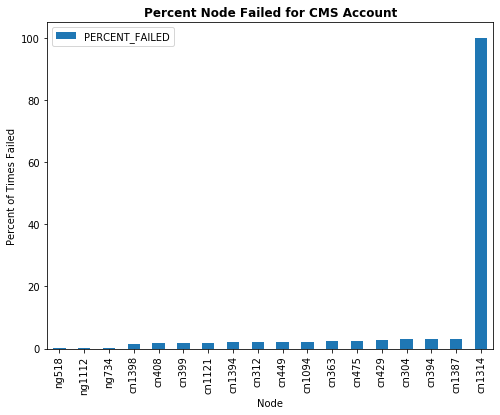

In [39]:
#plotted with one outlier, maybe remove it to make it easier to see
ax = CMS_nodes_df.sort_values('PERCENT_FAILED').plot.bar(x = 'NODE', y = 'PERCENT_FAILED', figsize = (8,6))
ax.set_title('Percent Node Failed for CMS Account',weight='bold', size='large')
ax.set_xlabel('Node')
ax.set_ylabel('Percent of Times Failed')

Text(0, 0.5, 'Percent of Times Failed')

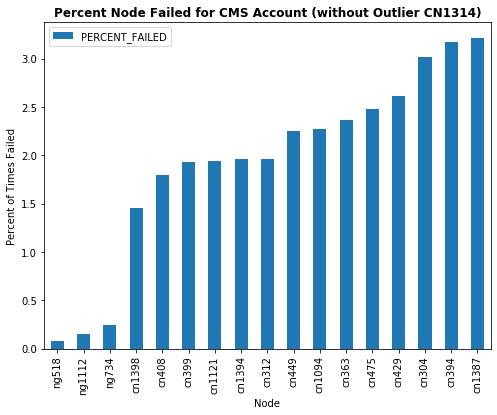

In [40]:
#removed cn 1314 to make it to make it easier to see,  label this graph
CMS_nodes_without_cn1314 = CMS_nodes_df[CMS_nodes_df['NODE'] != 'cn1314']
ax = CMS_nodes_without_cn1314.sort_values('PERCENT_FAILED').plot.bar(x = 'NODE', y = 'PERCENT_FAILED',figsize = (8,6))
ax.set_title('Percent Node Failed for CMS Account (without Outlier CN1314)',weight='bold', size='large')
ax.set_xlabel('Node')
ax.set_ylabel('Percent of Times Failed')

In [256]:
CMS_nodes_df.sort_values('PERCENT_FAILED', ascending = False).head(10)

,NODE,TIMES_FAILED,TOTAL_TIMES_USED,PERCENT_FAILED
1,cn1314,12,12,100.000000
12,cn1387,8,249,3.212851
2,cn394,11,347,3.170029
9,cn304,9,298,3.020134
15,cn429,8,306,2.614379
4,cn475,9,364,2.472527
14,cn363,8,339,2.359882
5,cn1094,9,397,2.267003
7,cn449,9,400,2.250000
17,cn312,8,407,1.965602
